In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics
import numpy as np
from transformers import BertTokenizer, TFBertModel, BertConfig, XLNetTokenizer, TFXLNetModel, AutoTokenizer, \
    TFAutoModel
from eval_func import normalize
from math import log2
from scipy import stats
from pathlib2 import Path
import os

2021-12-21 10:23:22.007472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 10:23:22.007508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def prepare_data(data_dir, language):
    if language == "Chinese":
        train_path = data_dir / "train_cn.json"
        test_path = data_dir / "test_cn.json"
        dev_path = data_dir / "dev_cn.json"

    elif language == "English":
        train_path = data_dir / "train_en.json"
        test_path = data_dir / "test_en.json"
        dev_path = data_dir / "dev_en.json"

    else:
        raise ValueError("Language must be English or Chinese")

    if not os.path.isfile(test_path):
        test_path = None

    return train_path, dev_path, test_path

data_dir = "./dataset"
language = "Chinese"
train_path, dev_path, test_path = prepare_data(data_dir=Path(data_dir), language=language)
train_path, dev_path, test_path

(PosixPath('dataset/train_cn.json'), PosixPath('dataset/dev_cn.json'), None)

In [3]:
from data_loader import create_processor, create_dataset
from model import create_dialogue_model
processor, embedding_size = create_processor(plm="BERT", max_len=200, language="Chinese")
train_dataset = create_dataset(processor=processor, json_path=str(train_path),
                                            mode="train", task="quality",
                                            shuffle_buffer_size=5000,
                                            batch_size=8)
val_dataset = create_dataset(processor=processor, json_path=str(dev_path),
                                          mode="validate", task="quality",
                                          shuffle_buffer_size=5000,
                                          batch_size=8)
model = create_dialogue_model(plm_name="BERT", language="Chinese",
                                           max_turn_number=7,
                                           embedding_size=embedding_size, max_len=200, ff_size=768,
                                           layer_num=1,
                                           dropout=0.1, task="quality")

2021-12-21 10:23:28.563942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-21 10:23:28.563977: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 10:23:28.563991: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-EFG9I9T): /proc/driver/nvidia/version does not exist
2021-12-21 10:23:28.564159: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['m

In [4]:
model.summary()

Model: "dialogue_quality"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 200)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 200)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 sentence_ids (InputLayer)      [(None, 7)]          0           []                               
                                                                                   

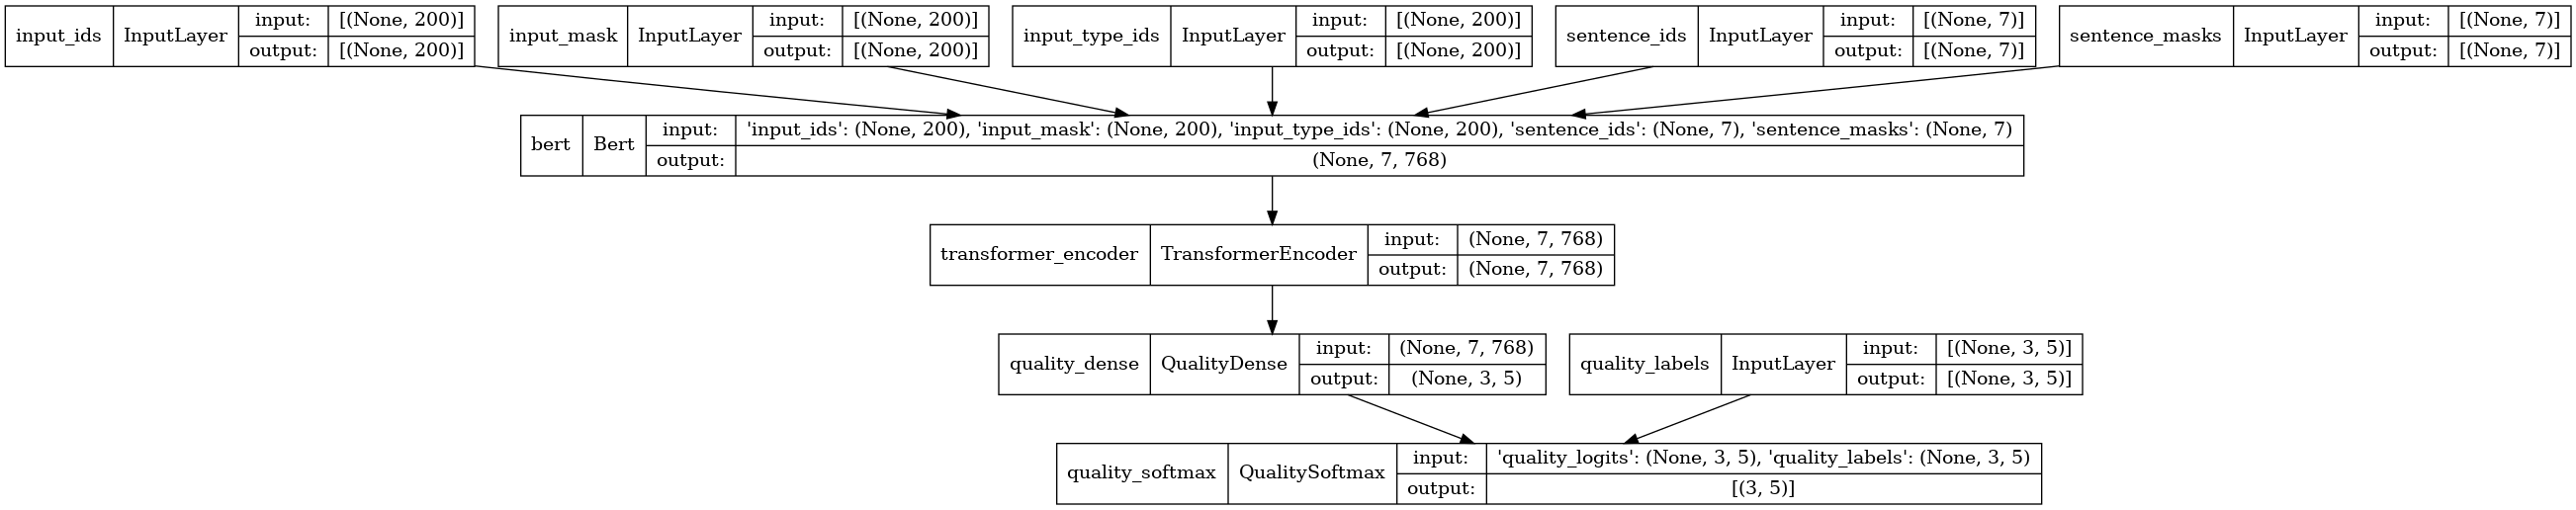

In [5]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [6]:
ckpt_path = "./checkpoint/"

In [7]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=1, monitor="val_A", save_best_only=True, mode="max")

In [8]:
history = model.fit(x=train_dataset, epochs=3, verbose="auto",
                                                   callbacks=callback, validation_data=val_dataset, 
                    steps_per_epoch=512)

Epoch 1/3
  7/512 [..............................] - ETA: 55:25 - loss: 1.6092 - A: 2.9880 - E: 2.9093 - S: 2.8476WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


KeyboardInterrupt: 